In [1]:
import numpy as np
from image_tools import ImageTools
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import matplotlib.cm as cm # To generate distinct colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
rgb_image = np.load("../../camera_data/color_data.npy")
depth_image = np.load("../../camera_data/depth_data.npy") * 1000
# rgb_image = cv2.imread("../../camera_data/gripper_camera_frame_0000.png")
# depth_image = np.load("../../camera_data/gripper_depth_data_0000.npy")

image_tools = ImageTools("./models/best.pt", "./models/FastSAM-s.pt")


Loading YOLO model from: ./models/best.pt
Loading FastSAM model from: ./models/FastSAM-s.pt
Models loaded.


In [3]:
print(rgb_image.shape)
print(depth_image.shape)

(480, 640, 3)
(480, 640)


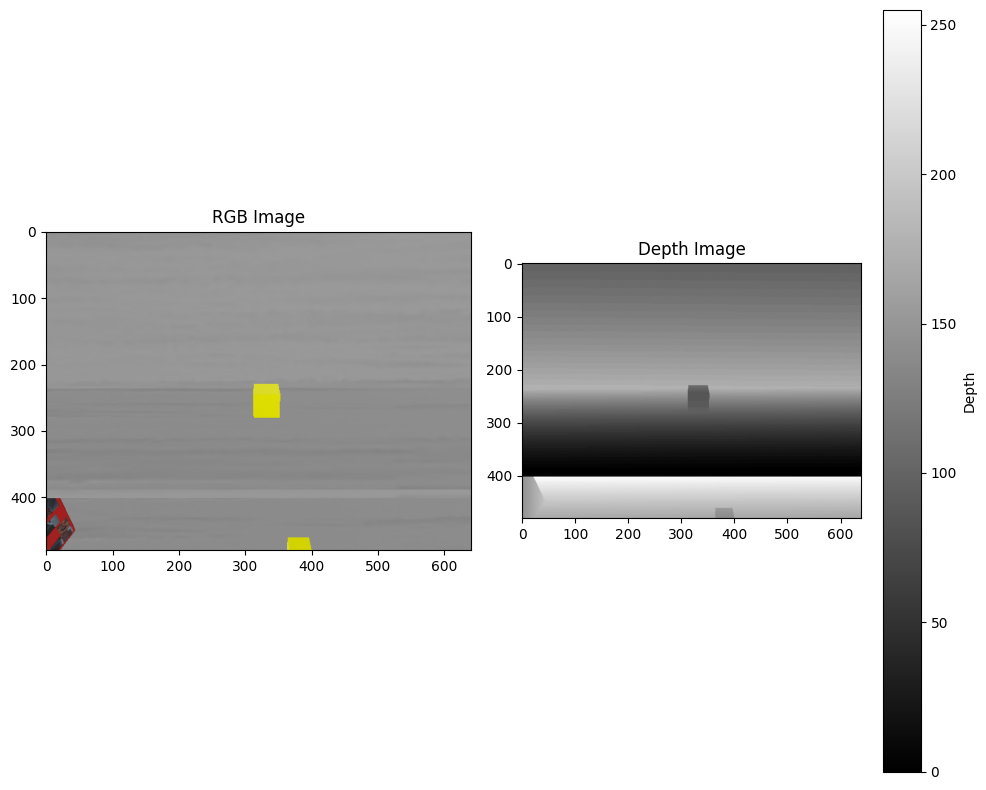

In [4]:
# Display the RGB image
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
plt.title('RGB Image')
plt.axis('on')

# Display the depth image
plt.subplot(1, 2, 2)
# Normalize the depth data for visualization
depth_min = np.min(depth_image[np.isfinite(depth_image)])
depth_max = np.max(depth_image[np.isfinite(depth_image)])

# Create a mask for invalid values (NaN or inf)
invalid_mask = ~np.isfinite(depth_image)

# Create normalized array
normalized_depth = np.full_like(depth_image, 255, dtype=np.float32)
if depth_max > depth_min:
    # Only normalize valid values
    normalized_depth[~invalid_mask] = (depth_image[~invalid_mask] - depth_min) / (depth_max - depth_min) * 255
normalized_depth = normalized_depth.astype(np.uint8)

plt.imshow(normalized_depth, cmap='gray')
plt.colorbar(label='Depth')
plt.title('Depth Image')

plt.tight_layout()
plt.show()


In [5]:
depth_image.max()

989.9999499320984

In [6]:
rgb_image.max()

223

In [7]:
# Parameters from the file
width = 640
height = 480
fov_x_rad = 1.49

# Calculate principal point
cx = width / 2
cy = height / 2

# Calculate focal length
fx = (width / 2) / np.tan(fov_x_rad / 2)
fy = fx # Assuming square pixels

# Construct the intrinsic matrix
intrinsic_matrix = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0, 0, 1]
])
# Create a PinholeCameraIntrinsic object from the intrinsic matrix parameters
# intrinsic_matrix = np.array([
#     [616.486, 0, 322.608],
#     [0, 616.819, 239.962],
#     [0, 0, 1]
# ])

# Also create an Open3D intrinsic object for point cloud operations

o3d_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    width=width,
    height=height,
    fx=intrinsic_matrix[0, 0],
    fy=intrinsic_matrix[1, 1],
    cx=intrinsic_matrix[0, 2],
    cy=intrinsic_matrix[1, 2]
)

# Test object detection with the created intrinsic matrix
# Note: This is a simplified test - real applications would need proper camera calibration
result_image, object_masks, object_point_clouds, detections = image_tools.process_and_extract_objects(rgb_image, depth_image, o3d_intrinsic)



0: 480x640 4 yellow cubes, 38.0ms
Speed: 5.0ms preprocess, 38.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 11 objects, 36.5ms
Speed: 1.0ms preprocess, 36.5ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)


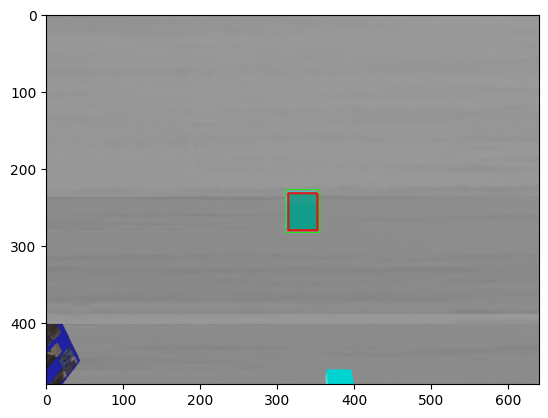

In [8]:
plt.imshow(result_image)

In [10]:

def view_object_point_clouds(object_point_clouds):
    """
    Visualizes a list of object point clouds in a single Open3D window,
    assigning a unique color to each point cloud.

    Args:
        object_point_clouds: A list of open3d.geometry.PointCloud objects.
    """
    if not object_point_clouds:
        print("No object point clouds to visualize.")
        return

    num_objects = len(object_point_clouds)
    # Generate distinct colors using a colormap (e.g., 'viridis', 'tab10', 'hsv')
    # Using 'tab10' which provides 10 distinct categorical colors, repeating if needed
    colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_objects))[:, :3] # Get RGB, discard alpha

    colored_pcds = []
    for i, pcd in enumerate(object_point_clouds):
        if not isinstance(pcd, o3d.geometry.PointCloud):
            print(f"Warning: Item at index {i} is not an Open3D PointCloud. Skipping.")
            continue
        if not pcd.has_points():
             print(f"Warning: Point cloud at index {i} has no points. Skipping.")
             continue

        # Create a copy to avoid modifying the original point cloud
        pcd_copy = o3d.geometry.PointCloud(pcd)

        # Assign a unique color to all points in this specific point cloud
        object_color = colors[i % len(colors)] # Use modulo in case num_objects > num colors in map
        pcd_copy.paint_uniform_color(object_color)
        colored_pcds.append(pcd_copy)

    if not colored_pcds:
        print("No valid point clouds found to visualize after filtering.")
        return

    # Visualize all colored point clouds together
    print(f"Visualizing {len(colored_pcds)} object point clouds. Close the window to continue.")
    o3d.visualization.draw_geometries(colored_pcds)


In [11]:
view_object_point_clouds([object_point_clouds])

Visualizing 1 object point clouds. Close the window to continue.


C:\Users\gamer\AppData\Local\Temp\ipykernel_63972\1617691143.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')(np.linspace(0, 1, num_objects))[:, :3] # Get RGB, discard alpha


In [ ]:
object_masks

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

: 